In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Glove vectors
from tqdm import tqdm                 ## Progress bar for loading GloVe embeddings
from nltk import word_tokenize        ## For GloVe

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

from tensorflow import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence
from keras import utils
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [2]:
## Check if GPU is loaded
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [3]:
## Check specs of GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11458346327084117496
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7398526917588082570
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2589489559239095514
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3234220936230565493
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
!nvidia-smi

Mon Oct 21 11:28:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    56W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!ls

gdrive	sample_data


In [0]:
#!mkdir "/content/gdrive/My Drive/chapter_clf/"
#!cd "/content/gdrive/My Drive/chapter_clf/"

In [0]:
#!mv qs_topicwise.json 'gdrive/My Drive/chapter_clf'

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Extract subject wise training data

In [8]:
# Load the dataset and show sample question
with open('/content/gdrive/My Drive/chapter_clf/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['PHY']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
for PHY - removing Stopwords reduce acc & f1 score : 67% -> 63%, 74% -> 72%
for CHM - removing Stopwords reduce acc & f1 score by 6%
for MTH - 
'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, removing nos improved accuracy & F1 score by 0.5%
        For CHM, removing nos improved acc by 2%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        '''
        For CHM, removing this regex improved score by 9%
        '''
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        '''
        For CHM, keeping both sets of words, instead of removing them improved acc by 5%
        '''
        #question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'],curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of the following changes can increase the stopping potential,Modern Physics
1,keeping the frequency as well the intensity of light source constant if we gradually increase the potential of anode giving it a positive potential w r t cathode,Modern Physics
2,two photons photon photon are travelling in vacuum consider the following cases case when the photons are travelling in same direction case when the photons are travelling in opposite directions the speed of photon w r t photon,Modern Physics


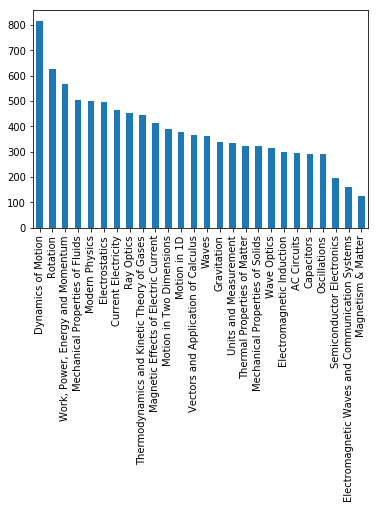

In [9]:
trainDF.label.value_counts().plot(kind="bar")

### Train test split

In [10]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8061 2016


#### Label Encoding
Label encoding is not needed for sklearn classifiers, as they are all capable of mutli-class classification, and handle label encoding automatically. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

For non-sklearn models like NNs or XGB, we need to do label encoding

In [11]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)
valid_y[0:5]

array([19, 12,  4, 18, 12])

### Glove vectors
Loading GloVe embeddings from Standford dataset : http://www-nlp.stanford.edu/data/glove.840B.300d.zip

Already stored in Google Drive. 
Downloading takes roughly takes 16-20 mins


In [0]:
#!curl 'http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip' --output 'glove.840B.300d.zip'
## Opening zip file
#!unzip 'glove.840B.300d.zip' 

In [12]:
## Source - https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
## Load the GloVe vectors in a dictionary. Create a map of words to vectors
## Roughly takes 3-4 mins

embeddings_index = {}
f = open('/content/gdrive/My Drive/chapter_clf/glove.840B.300d.txt', 'r', encoding='utf8', errors = 'ignore')

for line in tqdm(f):     ## tqdm adds a progress bar
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:47, 9635.48it/s] 

Found 2195892 word vectors.


In [0]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [14]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_x)]
xvalid_glove = [sent2vec(x) for x in tqdm(valid_x)]

100%|██████████| 2016/2016 [00:00<00:00, 2649.97it/s]


In [0]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

### Trying LSTM on GloVe features
Source : https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [0]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [0]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(train_y)
yvalid_enc = np_utils.to_categorical(valid_y)

In [18]:
### No of classes in the last layer - No of labels to classify
last_layer = len(ytrain_enc[0])
print(last_layer)

26


In [19]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(last_layer))                       ## No of classes to predict
model.add(Activation('softmax'))
model.summary()
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_

In [20]:
start = time()
history = model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))
end = time()
print('Total training time {} seconds'.format(end - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8061 samples, validate on 2016 samples
Epoch 1/10





8061/8061 [==============================] - 5s 667us/step - loss: 1.7258 - acc: 0.5197 - val_loss: 0.9702 - val_acc: 0.7267
Epoch 2/10
8061/8061 [==============================] - 1s 153us/step - loss: 0.9919 - acc: 0.7093 - val_loss: 0.8520 - val_acc: 0.7535
Epoch 3/10
8061/8061 [==============================] - 1s 154us/step - loss: 0.8172 - acc: 0.7533 - val_loss: 0.7824 - val_acc: 0.7708
Epoch 4/10
8061/8061 [==============================] - 1s 152us/step - loss: 0.7019 - acc: 0.7859 - val_loss: 0.7744 - val_acc: 0.7768
Epoch 5/10
8061/8061 [==============================] - 1s 161us/step - loss: 0.6185 - acc: 0.8101 - val_loss: 0.7783 - val_acc: 0.7783
Epoch 6/10
8061/8061 [==============================] - 1s 154us/step - loss: 0.5573 - acc: 0.8258 - val_loss: 0.7570 - val_acc: 0.7872
Epoch 7/10
8061/8061 [============

In [0]:
## Function to plot the history of accuracy & loss across epochs
def plot_history(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.ylim(ymin=0)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim(ymin=0)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


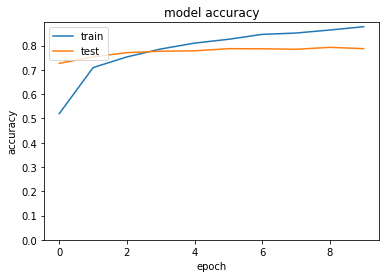

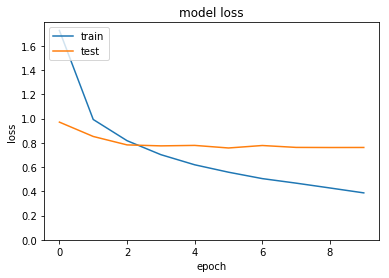

In [22]:
plot_history(history)

#### Much higher validation accuracy than what we've seen with other algorithms with a very simple network and no hyper-param tuning

In [0]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(train_x) + list(valid_x))
xtrain_seq = token.texts_to_sequences(train_x)
xvalid_seq = token.texts_to_sequences(valid_x)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [24]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 6565/6565 [00:00<00:00, 356896.11it/s]


In [25]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(last_layer))                            ## Num of classes to predict
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           1969800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

In [26]:
start = time()
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))
end = time()
print('Total training time {} seconds'.format(end - start))

Train on 8061 samples, validate on 2016 samples
Epoch 1/100
8061/8061 [==============================] - 4s 519us/step - loss: 3.1987 - acc: 0.0773 - val_loss: 3.1225 - val_acc: 0.1071
Epoch 2/100
8061/8061 [==============================] - 3s 358us/step - loss: 3.0641 - acc: 0.1125 - val_loss: 2.7333 - val_acc: 0.2113
Epoch 3/100
8061/8061 [==============================] - 3s 361us/step - loss: 2.7033 - acc: 0.2046 - val_loss: 2.1397 - val_acc: 0.3428
Epoch 4/100
8061/8061 [==============================] - 3s 363us/step - loss: 2.3167 - acc: 0.2825 - val_loss: 1.7788 - val_acc: 0.4415
Epoch 5/100
8061/8061 [==============================] - 3s 362us/step - loss: 2.0617 - acc: 0.3661 - val_loss: 1.5558 - val_acc: 0.5050
Epoch 6/100
8061/8061 [==============================] - 3s 364us/step - loss: 1.8639 - acc: 0.4219 - val_loss: 1.3847 - val_acc: 0.5605
Epoch 7/100
8061/8061 [==============================] - 3s 358us/step - loss: 1.7040 - acc: 0.4647 - val_loss: 1.2513 - val_acc: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


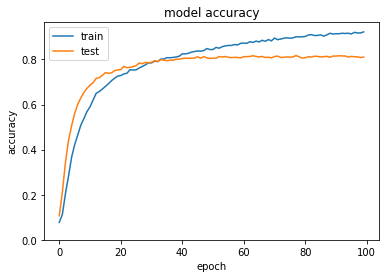

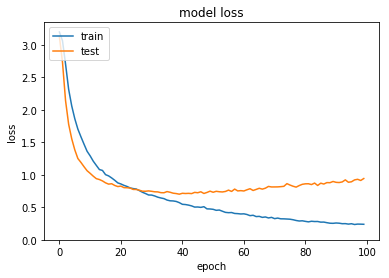

In [27]:
plot_history(history)

In [30]:
## Adding early stopping
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(last_layer))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          #verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])   ## Lower val acc due to Early Stopping
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 300)           1969800   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 70, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)             

#### Effects of Dropout
We see that the training loss is higher than validation loss and,
training accuracy is lower than validation accuracy.

"Why is the training loss much higher than the testing loss?
A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.
Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss." - Source - Keras FAQs

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


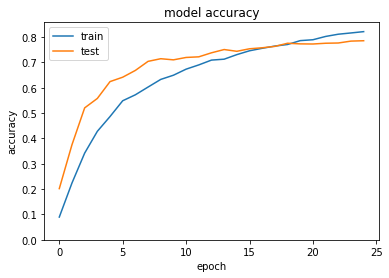

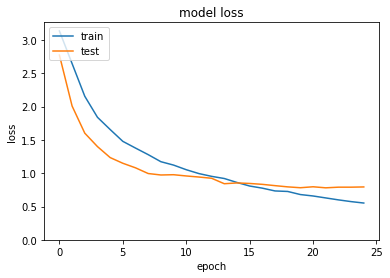

In [31]:
plot_history(history)

In [33]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(last_layer))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          #verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])  ## Lower val acc due to Early Stopping
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=None)

Train on 8061 samples, validate on 2016 samples
Epoch 1/100
8061/8061 [==============================] - 11s 1ms/step - loss: 3.1520 - acc: 0.0863 - val_loss: 2.9062 - val_acc: 0.1632
Epoch 2/100
8061/8061 [==============================] - 8s 1ms/step - loss: 2.6239 - acc: 0.2249 - val_loss: 1.9511 - val_acc: 0.3839
Epoch 3/100
8061/8061 [==============================] - 8s 1ms/step - loss: 2.0870 - acc: 0.3578 - val_loss: 1.5713 - val_acc: 0.5094
Epoch 4/100
8061/8061 [==============================] - 8s 1ms/step - loss: 1.8116 - acc: 0.4302 - val_loss: 1.3891 - val_acc: 0.5561
Epoch 5/100
8061/8061 [==============================] - 8s 1ms/step - loss: 1.6276 - acc: 0.4903 - val_loss: 1.2692 - val_acc: 0.6071
Epoch 6/100
8061/8061 [==============================] - 8s 1ms/step - loss: 1.4650 - acc: 0.5391 - val_loss: 1.1467 - val_acc: 0.6642
Epoch 7/100
8061/8061 [==============================] - 8s 1ms/step - loss: 1.3441 - acc: 0.5756 - val_loss: 1.0566 - val_acc: 0.6845
Epoch 

We have now got a training set accuracy of close to 98%, so no need to make the network more complex or bigger !

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


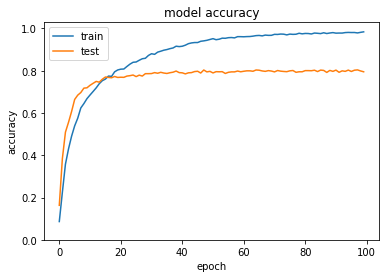

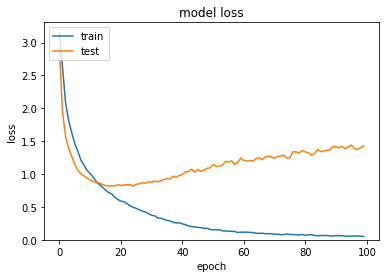

In [34]:
plot_history(history)

In [35]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(last_layer))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          #verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=None)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 300)           1969800   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 70, 300)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 300)           540900    
_________________________________________________________________
gru_2 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)             

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


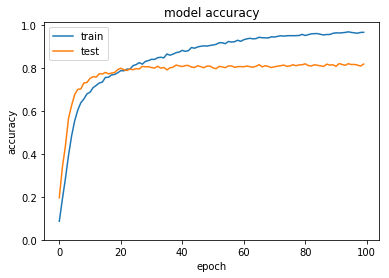

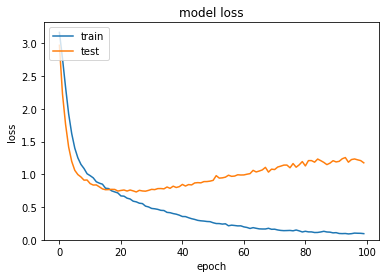

In [36]:
plot_history(history)